In [1]:
# !rm -rf Busway-Traffic-Violation-Detection
# !git clone https://github.com/ariqbasyar/Busway-Traffic-Violation-Detection.git\
#   && cd /content/Busway-Traffic-Violation-Detection/\
#   && git checkout lane-detection

In [2]:
# %cd /content/Busway-Traffic-Violation-Detection/model/busway-lane-detection-yolo/

In [3]:
# !pip install Shapely

In [4]:
!ls

LICENSE    dataset	  example.py	    model.py  requirements.txt	utils
README.md  example.ipynb  experiment.ipynb  models    service		weights


In [5]:
import importlib

import sys
import os
import torch
import numpy as np
import cv2

from model import preprocess, detect, box_label, get_busway_box_from_prediction
from time import time
from pathlib import Path
from models.experimental import attempt_load

from matplotlib import pyplot as plt
%matplotlib inline

os.environ['CUDA_VISIBLE_DEVICES'] = "7" # set GPU to GPU7

requirements: /workspace/Busway-Traffic-Violation-Detection/Pillow>=8.4.0 not found, check failed.


In [6]:
ROOT = Path('/workspace/Busway-Traffic-Violation-Detection')
weight_vehicle_detection = ROOT / 'weights/yolov5m-car-detection.pt'
weight_busway_lane = ROOT / 'weights/best-yolov5m-400epochs.pt'

In [7]:
random_state = np.random.RandomState(42)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using {device}')
vehicle_detection_model = attempt_load(weight_vehicle_detection, map_location=device)
busway_lane_detection_model = attempt_load(weight_busway_lane, map_location=device)

using cuda


Fusing layers... 
Model Summary: 308 layers, 21053802 parameters, 0 gradients, 50.4 GFLOPs
Fusing layers... 
Model Summary: 308 layers, 21049761 parameters, 0 gradients


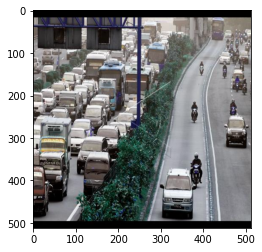

In [9]:
idx = '%03d.jpg' % random_state.randint(0,62)
main_img = cv2.imread(f'dataset/preprocessed_512x512/{idx}')
plt.imshow(main_img)
plt.show()

# Preprocess

In [10]:
preprocessed = preprocess(main_img,device)

# Detect

In [11]:
start = time()
pred_busway = detect(busway_lane_detection_model,preprocessed)
pred_vehicle = detect(vehicle_detection_model,preprocessed)
print(f'inferenced in {(time() - start)*1E3:.2f}ms')

inferenced in 81.99ms


# Plot

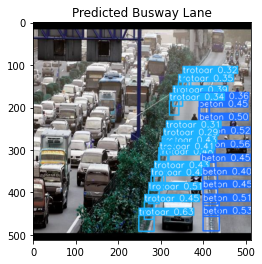

In [12]:
labeled_img = box_label(pred_busway,main_img.copy())
plt.imshow(labeled_img)
plt.title("Predicted Busway Lane")
plt.show()

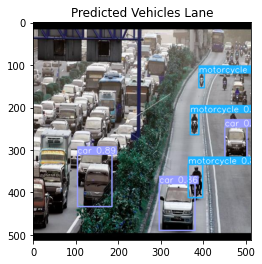

In [13]:
#filter vehicle labels: exclude 2: jalur_busway
pred_vehicle = [i for i in pred_vehicle if i[6] != 'jalur_busway']

labeled_img = box_label(pred_vehicle,main_img.copy())
plt.imshow(labeled_img)
plt.title("Predicted Vehicles Lane")
plt.show()

amount of convex hull points: 9


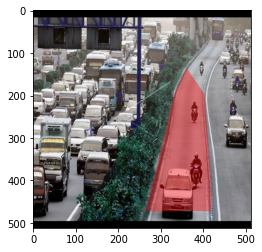

In [14]:
busway_polygon = get_busway_box_from_prediction(pred_busway)
x,y = busway_polygon.exterior.xy

points = np.int32([x,y])
points = points.transpose()
print(f'amount of convex hull points: {len(points)}')
if points is None:
  print("Cant make polygon from the prediction")
else:
  _img = main_img.copy()
  cv2.fillPoly(_img, [points], (255,0,0))
  alpha = 0.4
  image_new = cv2.addWeighted(_img, alpha, main_img.copy(), 1 - alpha, 0)
  plt.imshow(image_new)
  plt.show()

# Traffic Violation Inference

In [15]:
def generate_center_from_rectangle(x0, y0, x1, y1):
    return (x0+(x1-x0)/2, y0+(y1-y0)/2)

def extract_points_from_yolo(pred_item):
    return pred_item[0], pred_item[1], pred_item[2], pred_item[3]

In [16]:
from collections import Counter
from shapely.geometry import Polygon, Point
violating_vehicles = []

for vehicle in pred_vehicle:
    if (vehicle[6] == 'bus'):
        continue
    car_center = generate_center_from_rectangle(*extract_points_from_yolo(vehicle))
    point = Point(car_center)
    if (busway_polygon.intersects(point)):
        violating_vehicles.append(vehicle[6])

print("Violation Count:", len(violating_vehicles))
print("Details:", Counter(violating_vehicles))

Violation Count: 3
Details: Counter({'motorcycle': 2, 'car': 1})
